### Introduction

The purpose of this notebook is to evaluate the encoder from inpainting.ipynb in classifying osteoarthritis (OA) severity. Specifically, we will observe whether using weights learned from performing inpainting improves classifier performance.


Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install the necessary dependencies.

In [ ]:
!pip install torcheval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 13.3 MB/s eta 0:00:00


Import the required libraries.

In [ ]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torch.utils.data import random_split
import torch.optim as optim
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

Load the dataset from Google Drive and preprocess the images. There are 2352 images with the following OA severity distribution: 932 "Grade 0", 428 "Grade 1", 615 "Grade 2", 306 "Grade 3", and 71 "Grade 4".

In [ ]:
# Specify the data directory
DATAROOT = '/content/drive/MyDrive/OSAIL_Data/Labeled'

# Standardize the images the using torchvision.transforms library
IMG_SIZE = 128
transformations = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
    transforms.Grayscale(1)
])

# Load the dataset and apply the transformations
dataset = datasets.ImageFolder(root=DATAROOT, transform=transformations)

Randomly generate training, validation, and testing sets with an 80/10/10% split.

In [ ]:
VALID_SIZE = 0.1 # The proportion of the dataset to be used for validation
TEST_SIZE = 0.1 # The proportion of the dataset to be used for testing
BATCH_SIZE = 16

# Randomly split the dataset into training, validating, and testing sets
generator = torch.Generator().manual_seed(42)
train, valid, test = random_split(dataset, [0.8, VALID_SIZE, TEST_SIZE], generator=generator)

# Initialize the PyTorch DataLoader class
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE)

# Display the number of images in each subset
print('Train: ' + str(len(train_loader.dataset.indices)),
      '\nValidate: ' + str(len(valid_loader.dataset.indices)), '\nTest: ' + str(len(test_loader.dataset.indices)))

Train: 1882 
Validate: 235 
Test: 235


Define the model, which consists of the encoder from the inpainting generator.

In [ ]:
class Encoder(nn.Module):
    """The encoder module of the generator from the inpainting task"""
    def __init__(self, channels=3):
        super(Encoder, self).__init__()
        def downsample(in_feat, out_feat, normalize=True):
            """Each layer consists of convolution, batch normalization, and activation"""
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        self.model = nn.Sequential(
            *downsample(channels, 64, normalize=False),
            *downsample(64, 64),
            *downsample(64, 128),
            *downsample(128, 256),
            *downsample(256, 512),
        )

        self.flattened_tensor = nn.Flatten()

        # Add a classification layer on top of the encoder in order to generate predictions
        self.classifier_head = nn.Sequential(
            nn.Linear(8192, 512),
            nn.ReLU(),
            nn.Linear(512, 5),
            nn.LogSoftmax(dim=1))

    def forward(self, x):
        conv_output = self.model(x)
        flattened_output = self.flattened_tensor(conv_output)
        output = self.classifier_head(flattened_output)
        return output

Define an "early stopping" class that will be used to terminate training once validation loss shows an increasing trend.

In [ ]:
class EarlyStopper:
    """Implements early stopping to reduce overfitting"""
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        """Stops training if the validation_loss increases by a specified
        amount (min_delta) over a specified number of epochs (patience)
        """
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

Define a class that implements Focal Loss as a modification of Cross Entropy Loss. Focal Loss generally performs better than Cross Entopy Loss in cases of class imbalance due to its gamma "focusing" parameter.

In [ ]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    "Focal loss implemented using F.cross_entropy"
    def __init__(self, gamma: float = 2.0, weight=None, reduction: str = 'mean') -> None:
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, inp: torch.Tensor, targ: torch.Tensor):
        ce_loss = F.cross_entropy(inp, targ, weight=self.weight, reduction="none")
        p_t = torch.exp(-ce_loss)
        loss = (1 - p_t)**self.gamma * ce_loss
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()
        return loss

Train and validate the model.

In [ ]:
%%time

# Define the two models - one that uses pretrained weights (Transfer) and one that does not (Naive)
transfer_model, naive_model = Encoder(channels=1), Encoder(channels=1)
transfer_model.load_state_dict(torch.load("/content/drive/MyDrive/generator.pth"), strict=False)
models = {naive_model: 'Naive', transfer_model: 'Transfer'}

# Find the device available to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = {naive_model: 'Naive', transfer_model: 'Transfer'}
for model, name in models.items():
    model = model
    print(name)
    # Set the loss function to Negative Log Liklihood Loss and the optimizer to Adam
    criterion = FocalLoss()
    optimizer = optim.Adam(model.parameters())
    # Load the model to the specified device
    model.to(device)
    # Initialize the Early Stopper such that training is terminated if validation loss increases
    # by 0.1 for two consecutive epochs
    early_stopper = EarlyStopper(patience=2, min_delta=0.1)
    epochs = 10
    for epoch in range(epochs):
        tqdm_bar = tqdm(train_loader, desc=f'Training Epoch {epoch} ', total=int(len(train_loader)))
        tqdm_val = tqdm(valid_loader, desc=f'Validation Epoch {epoch} ', total=int(len(valid_loader)))
        train_loss = 0
        val_loss = 0
        accuracy = 0

        # Train the model using forward and backward propagation
        model.train()
        counter = 0
        for i, (inputs, labels) in enumerate(tqdm_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model.forward(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*inputs.size(0)

            # Update progress
            tqdm_bar.set_postfix(train_loss=train_loss/len(train_loader.dataset))

        # Evaluate the model on the validation set
        model.eval()
        counter = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(tqdm_val):
                inputs, labels = inputs.to(device), labels.to(device)
                output = model.forward(inputs)
                valloss = criterion(output, labels)
                val_loss += valloss.item()*inputs.size(0)
                output = torch.exp(output)

                # Update progress
                tqdm_val.set_postfix(valid_loss=val_loss/len(valid_loader.dataset))

        # Keep track of the validation loss and call the early stopper as needed
        valid_loss = val_loss/len(valid_loader.dataset)
        if early_stopper.early_stop(valid_loss):
            break

Naive


Training Epoch 0 :   0%|          | 0/118 [00:00<?, ?it/s]

Validation Epoch 0 :   0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/118 [00:00<?, ?it/s]

Validation Epoch 1 :   0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch 2 :   0%|          | 0/118 [00:00<?, ?it/s]

Validation Epoch 2 :   0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch 3 :   0%|          | 0/118 [00:00<?, ?it/s]

Validation Epoch 3 :   0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch 4 :   0%|          | 0/118 [00:00<?, ?it/s]

Validation Epoch 4 :   0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch 5 :   0%|          | 0/118 [00:00<?, ?it/s]

Validation Epoch 5 :   0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch 6 :   0%|          | 0/118 [00:00<?, ?it/s]

Validation Epoch 6 :   0%|          | 0/15 [00:00<?, ?it/s]

Transfer


Training Epoch 0 :   0%|          | 0/118 [00:00<?, ?it/s]

Validation Epoch 0 :   0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/118 [00:00<?, ?it/s]

Validation Epoch 1 :   0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch 2 :   0%|          | 0/118 [00:00<?, ?it/s]

Validation Epoch 2 :   0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch 3 :   0%|          | 0/118 [00:00<?, ?it/s]

Validation Epoch 3 :   0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch 4 :   0%|          | 0/118 [00:00<?, ?it/s]

Validation Epoch 4 :   0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch 5 :   0%|          | 0/118 [00:00<?, ?it/s]

Validation Epoch 5 :   0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 1min 40s, sys: 4.82 s, total: 1min 45s
Wall time: 2min 23s


Test the model and obtain classification metrics.

Naive F1 Score: 0.455
Transfer F1 Score: 0.468


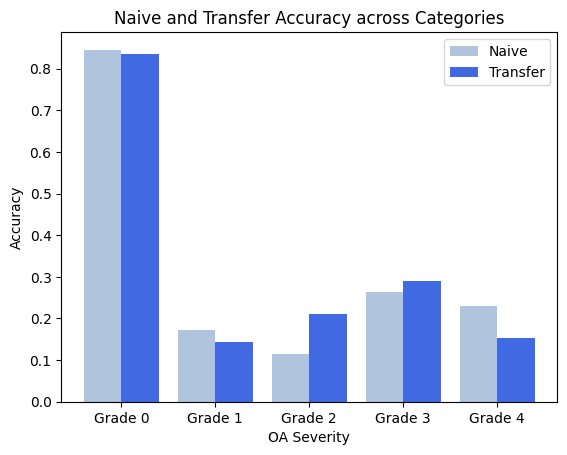

In [ ]:
# Set some parameters for plotting
x_axis_labels = ['Grade 0','Grade 1','Grade 2','Grade 3', 'Grade 4']
x_axis = np.arange(len(x_axis_labels))
adj = -0.2
ci = 0
colors = ['lightsteelblue', 'royalblue']

models = {naive_model: 'Naive', transfer_model: 'Transfer'}
for model, name in models.items():
    model = model
    # Evaluate the model on the test set
    model.eval()
    input = torch.empty(0, dtype=torch.int64).to(device)
    target = torch.empty(0, dtype=torch.int64).to(device)
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model.forward(inputs)
            output = torch.exp(output)
            # Obtain the model predictions
            top_p, top_class = output.topk(1, dim=1)
            input = torch.cat([input, top_class.squeeze()])
            target = torch.cat([target, labels])

    # Derive and plot the accuracy by class
    accuracy_tensor = multiclass_accuracy(input, target, num_classes=5, average=None)
    f1_tensor = multiclass_f1_score(input, target, num_classes=5)
    print(name + " F1 Score: " + str(f1_tensor.item())[:5])
    accuracies = []
    for acc in accuracy_tensor:
        accuracies.append(acc.item())
    plt.bar(x_axis + adj, accuracies, 0.4, label = name, color=colors[ci])
    adj +=0.4
    ci+=1

plt.xticks(x_axis, x_axis_labels)
plt.xlabel("OA Severity")
plt.ylabel("Accuracy")
plt.title("Naive and Transfer Accuracy across Categories")
plt.legend()
plt.show()

###Conclusion
Based on these results, there does not appear to be a clear benefit to pre-training on the inpainting task. Both models perform at an above chance level overall and significantly so in detecting Grade 0 Osteoarthritis, but they do not distinguish well between grades.

The model's performance could be improved in several ways: 1) augmenting the dataset by manipulating the images, 2) balancing the dataset by oversampling from the underrepresented classes, and 3) optimizing hyperparameters. Of course, these approaches would require more computing hours than were available.

Another possibility is to use the "Ordinal Loss" function as described in Fully Automatic Knee Osteoarthritis Severity Grading Using Deep Neural Networks with a Novel Ordinal Loss (Chen et al, 2019). Ordinal Loss assigns a higher penalty to misclassification with larger distance between the predicted Kellgren and Lawrence grade and the real grade. This could be helpful, considering that accuracy degrades beyond Grade 0, though it should be noted that Chen et al worked with a dataset about four times as large. They also - quite crucially - employed models that were pre-trained for image classification and were therefore able to achieve accuracy of upwards of close to 70%.

Clearly, there is considerable room for improvement, whether through transfer learning or task specific pre-training.